# Fit atmosphere parameters including clouds

- author Sylvie Dagoret-Campagne

- creation date August 19th 2020 : remove Rayleigh, add Linear (No reg) fit, mag or no mag fit


In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [141]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [142]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [143]:
import libatmscattering as atm

In [252]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        r'$\mu$={:3.2g}'.format(mu),
        r'$median$={:3.2g}'.format(median),
        r'$\sigma$={:3.2g}'.format(sigma)))
        
        print(mu,median,sigma)
        print(textstr)
        
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        #ax.set_ylim(mu-nsig*median,mu+nsig*median)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        print(mu,median,sigma)
        
        textstr = '\n'.join((
        '$\mu$={:3.3g}'.format(mu),
        '$median$={:3.3g}'.format(median),
        '$\sigma$={:3.3g}'.format(sigma)))
        print(textstr)
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        #ax.set_ylim(mu-nsig*median,mu+nsig*median)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])
    
    return cm
    

5.9915586926726645e-06 -2.5874541465332624e-06 0.00018670248645621536
$\mu$=5.99e-06
$median$=-2.59e-06
$\sigma$=0.000187
2.1267925464419374e-09 6.020202010608031e-09 4.714972171558306e-07
$\mu$=2.13e-09
$median$=6.02e-09
$\sigma$=4.71e-07
3.681076657541145e-09 -1.0054653208266047e-08 3.5968365375707156e-07
$\mu$=3.68e-09
$median$=-1.01e-08
$\sigma$=3.6e-07
-3.758272663911916e-05 2.7585935150223644e-07 0.0006175839877450169
$\mu$=-3.76e-05
$median$=2.76e-07
$\sigma$=0.000618


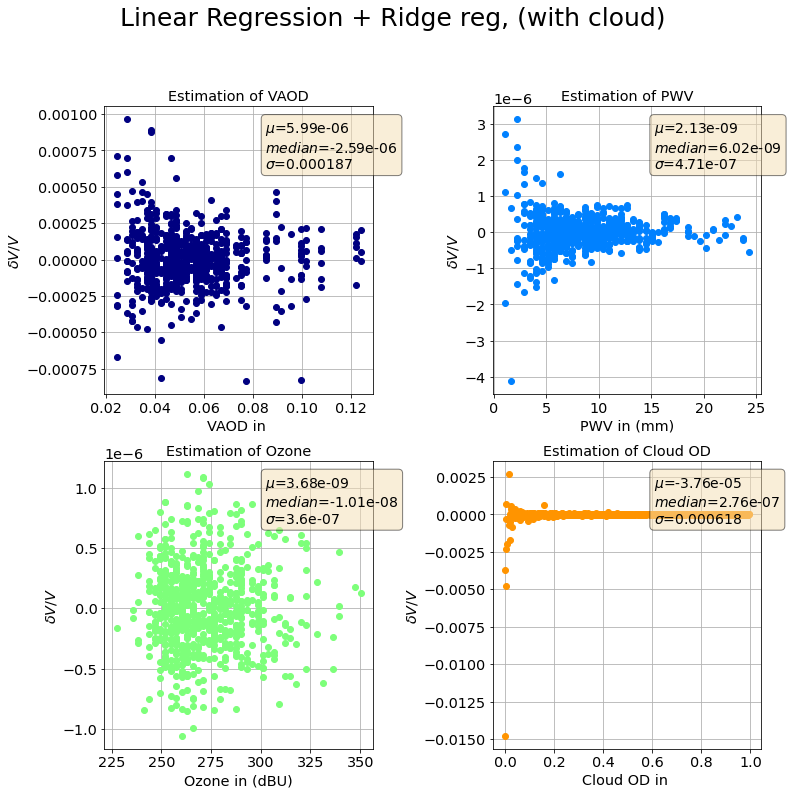

In [253]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [237]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=5):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    r'$\mu=%3.3f$' % (mu, ),
    r'$median=%3.3f$' % (median, ),
    r'$\sigma=%3.3f$' % (sigma, )))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    #ax.set_xlim(mu-nsig*median,mu+nsig*median)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    
    return cm
    

In [146]:
DATADIR="../../data/atm"

In [147]:
atmospheric_basename_files=os.listdir(DATADIR)

In [148]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [149]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [150]:
hdu = fits.open(input_file)

In [151]:
hdr=hdu[0].header
data=hdu[0].data

In [152]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [153]:
#NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [154]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [155]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm_tot=data[1:,idx_out_res:]

### Select wavelength range

In [156]:
WLMINSEL=340.
WLMAXSEL=1100.

In [157]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [158]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [159]:
len(indexes_selected)

760

In [160]:
wl=wl[indexes_selected]
transm_tot=transm_tot[:,indexes_selected]

### Remove rayleigh component

In [161]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [162]:
transm=transm_tot/att_rayleigh

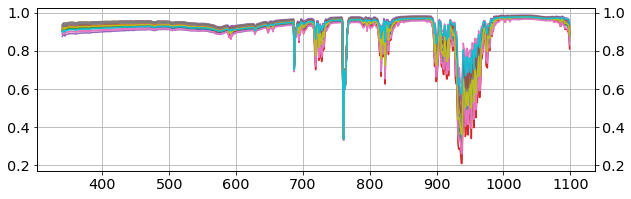

In [163]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(wl,transm[idx,:])
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax.grid()

In [164]:
NWL=wl.shape[0]

In [165]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [166]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

## Clouds

## clouds in input data

In [167]:
od_cloud_data=(cld-cld.min())/100
transm_cloud_data=np.exp(-od_cloud_data)

### add simulated clouds

In [168]:
od_cloud_sim=np.random.rand(len(vaodarr))
transm_cloud_sim=np.exp(-od_cloud_sim)

Text(0.5, 0, 'cloud optical depth')

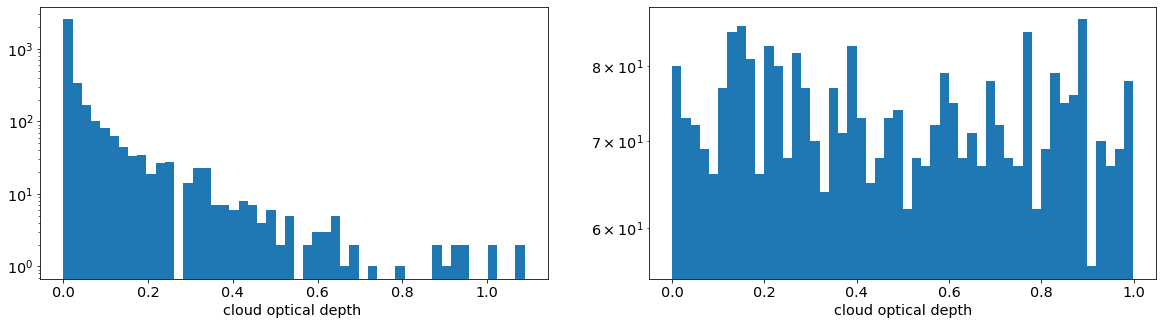

In [169]:
fig=plt.figure(figsize=(20,5))

ax = fig.add_subplot(121)
plt.hist(od_cloud_data,bins=50,label="in data")
ax.set_yscale('log')
ax.set_xlabel("cloud optical depth ")

ax = fig.add_subplot(122)
plt.hist(od_cloud_sim,bins=50,label="in sim")
ax.set_yscale('log')
ax.set_xlabel("cloud optical depth")

In [170]:
FLAG_CLOUD_SIM=True
if FLAG_CLOUD_SIM:
    cldarr=od_cloud_sim
else:
    cldarr=od_cloud_data
    
transm_cloud=np.exp(-cldarr)
transm_cloud=transm_cloud[:,np.newaxis]
cldarr=cldarr[:,np.newaxis]

### concatenate VAOD,PWV, Ozone

In [171]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)

### Use magnitudes for X

In [172]:
FLAG_MAG=True
if FLAG_MAG:
    X=-2.5*np.log10(transm*transm_cloud)
else:
    X=transm*transm_cloud

### Check transmission

(-0.10183497210344376, 2.634014063519703)

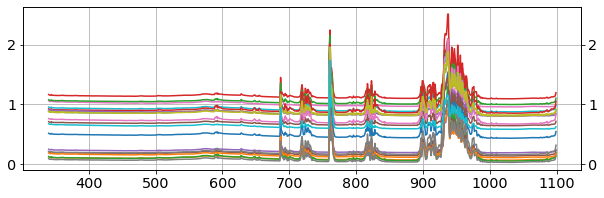

In [173]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(wl,X[idx,:])
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())

## Splitting

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [175]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [176]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [177]:
FLAG_SCALING=True

In [178]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [179]:
scaler_X.mean_.shape

(760,)

In [180]:
scaler_X.scale_.shape

(760,)

In [181]:
scaler_Y.mean_.shape

(4,)

In [182]:
scaler_Y.scale_.shape

(4,)

In [183]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

Text(0.5, 1.0, 'Renormalised target (VAOD, O3, PWV,CLD)')

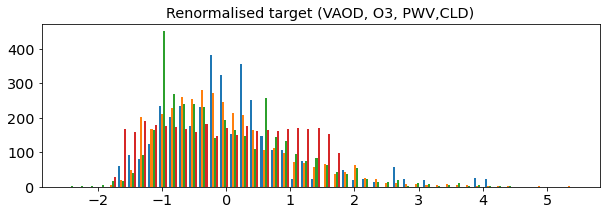

In [184]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
ax.set_title("Renormalised target (VAOD, O3, PWV,CLD)")

## Linear regression model

In [185]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [186]:
reg = linear_model.LinearRegression()

In [187]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [188]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[ 1.28069906e+01 -2.06352830e+01  3.56417591e+01 ...  4.33726464e+04
  -2.47705905e+02 -2.18169313e+02]
 [ 6.32092646e-03 -3.34443671e-02 -1.15756358e-01 ...  3.34163724e+01
   3.88443581e-02 -2.28060893e-01]
 [ 2.68983694e+00  2.40850724e+00  1.47461198e+00 ...  5.97721997e+02
  -9.89801325e-01 -6.97768336e-01]
 [-9.46979683e-01  1.49616328e+00 -2.60928500e+00 ... -3.17571608e+03
   1.80959967e+01  1.59349741e+01]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


# Linear Regression with Ridge

In [189]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [190]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[-1.01461601e+00 -7.62285643e-01 -6.60944334e-01 ... -1.49889671e+00
  -1.52901119e+00 -1.60002106e+00]
 [ 2.68221045e-03  2.26504404e-03  2.10873079e-03 ...  1.32406708e-01
   1.69786654e-01  6.60912396e-02]
 [ 3.02910522e+00  2.09775307e+00  1.71917622e+00 ...  5.25199001e-01
   5.68227898e-01  7.04953630e-01]
 [ 5.90124858e-02  4.52988133e-02  3.98360130e-02 ...  1.06922259e-01
   1.08952804e-01  1.13683549e-01]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


## Tune hyper parameter with Ridge

In [191]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.29191e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.03191e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.62135e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.78194e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.97803e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dag

<Figure size 1080x1080 with 0 Axes>

In [192]:
RIDGE_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [193]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [194]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

1e-10

1.6070528182616385e-06

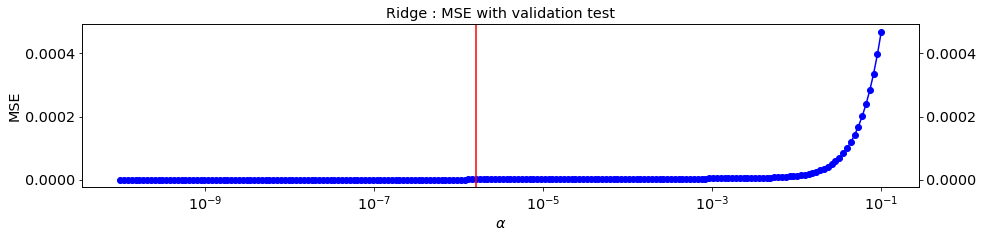

In [195]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE<1e-6)[0][-1]
else:
    idx_min=np.where(all_MSE<1e-6)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
alpha_ridge

### Display results

(-2.340129133712238e-05, 0.0004923870573936757)

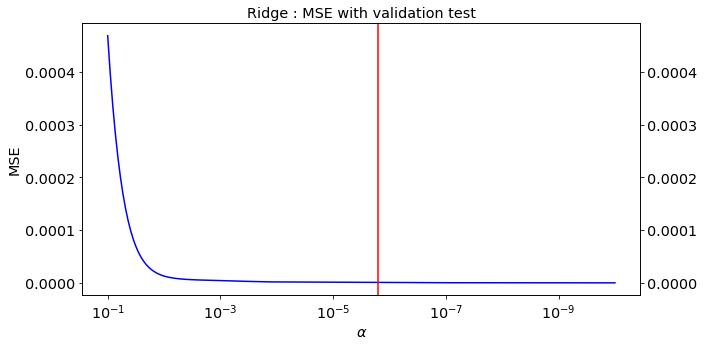

In [196]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())

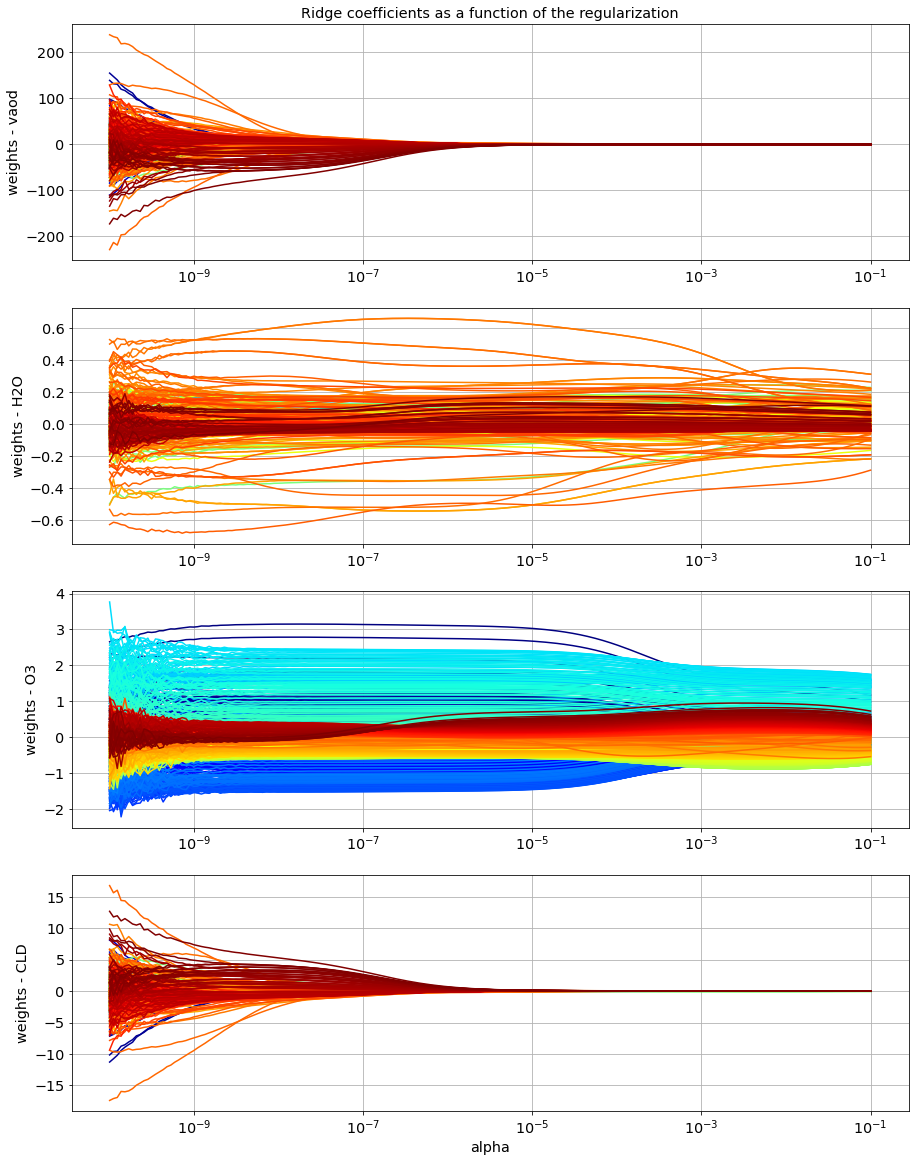

In [197]:
fig=plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.grid(True)


plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [198]:
from sklearn import linear_model

In [199]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [200]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.37949180730888, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0899834360363156, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074.3316050580636, tolerance: 0.2190000000000001
  positive)


Coefficients: 
 [[ 2.47416193e+01 -1.56701836e-02 -4.89511946e-02 ... -0.00000000e+00
  -0.00000000e+00  1.15784420e-01]
 [ 2.40714212e-01  0.00000000e+00  0.00000000e+00 ...  2.97833802e-18
   8.98388076e-02  1.38601750e-01]
 [ 5.18330792e-01 -1.73033448e+00 -6.75431034e-01 ...  2.64881977e-18
   1.23784436e-02 -0.00000000e+00]
 [-1.46905330e+00 -0.00000000e+00 -0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -0.00000000e+00]]
Mean squared error: 0.27379
Coefficient of determination: 0.74353
Explained variance: 0.74380


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2761899524059743, tolerance: 0.2190000000000002
  positive)


In [201]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.31034521556761, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5419193696654933, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1076.6131947199383, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.31290865991147, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5433347009951421, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1076.6079616889967, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.90166079713701, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8534491366765842, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1075.3743818572896, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043.1089863266577, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0209455614433804, tolerance: 0.2190000000000002
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.15634539874787, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase th

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7509582449173884, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.764679114525439, tolerance: 0.2190000000000002
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7260654039257588, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

<Figure size 1080x1080 with 0 Axes>

In [202]:
LASSO_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [203]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [204]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

0.0012742749857031321

0.0012742749857031321

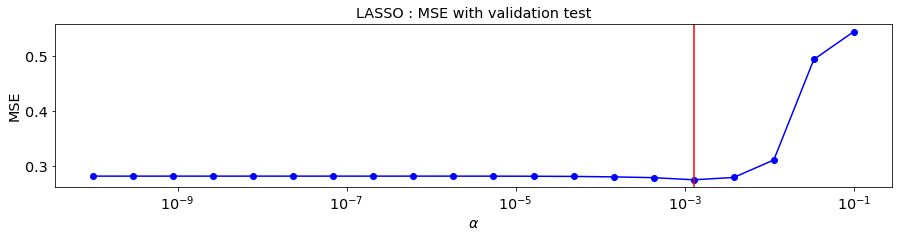

In [205]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
else:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
alpha_lasso

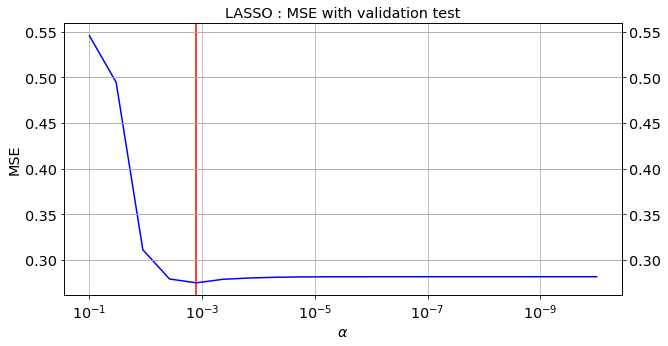

In [206]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.grid()
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

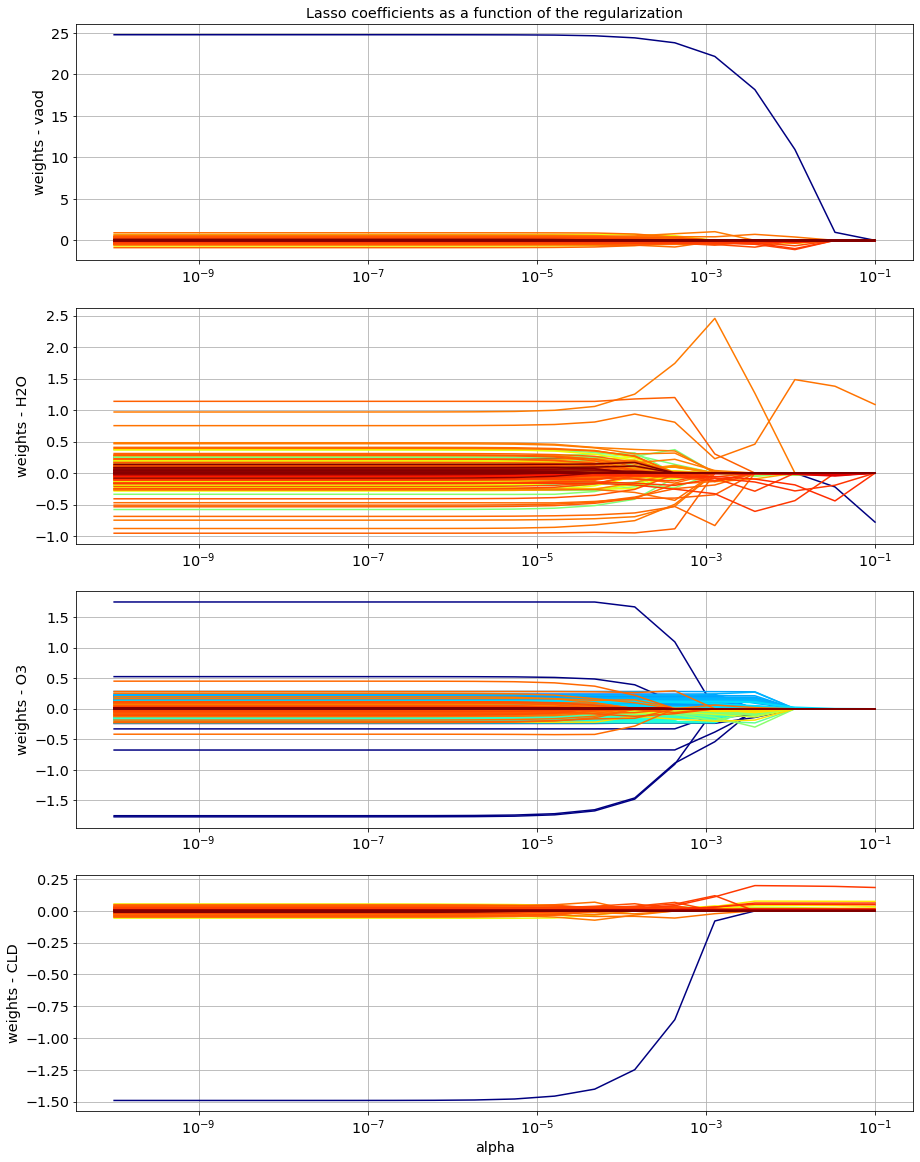

In [207]:
fig=plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [208]:
nb_tot_test=len(Y_test)

In [209]:
nsamples=np.arange(10,nb_tot_test,10)

### Leraning curves for linear regression

In [210]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [211]:
count=0
for n in nsamples:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    Y_pred_test  = regr.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

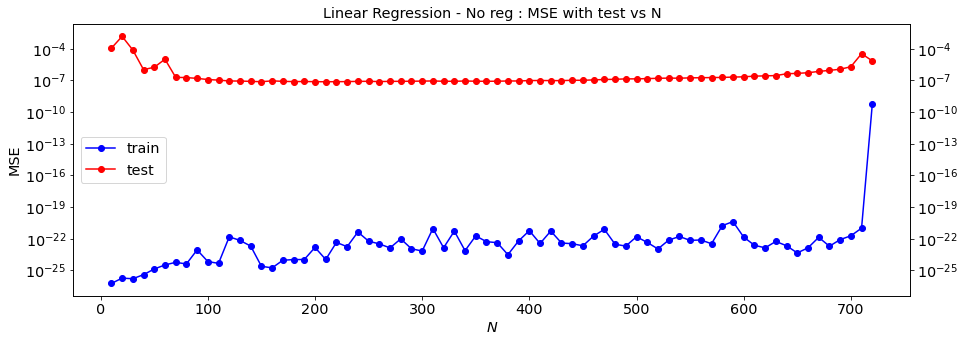

In [212]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax.grid()

### Learning curves for Ridge

In [213]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [214]:
alpha_ridge

1.6070528182616385e-06

In [215]:
alpha_ridge=1e-4

In [216]:
count=0
for n in nsamples:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.03052e-16): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.05543e-16): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.61893e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.35402e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.75034e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.24833e-17): result may not be accurate.
  overwrite_a=False)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.23329e-17): result may not be accurate.
  overwrite_a=False)


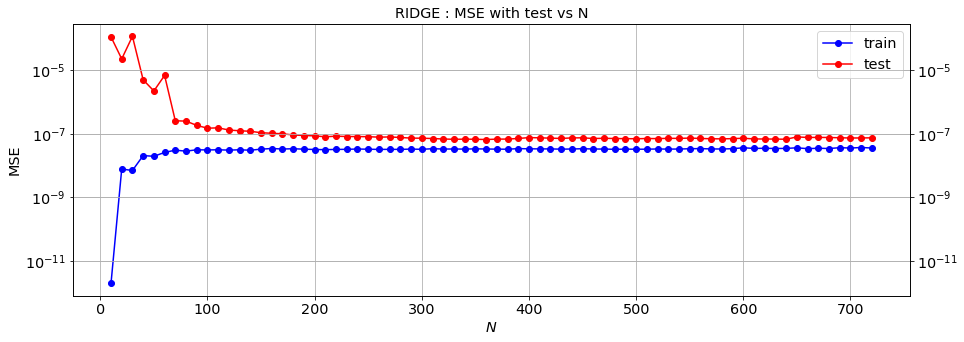

In [217]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [218]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [219]:
alpha_lasso

0.0012742749857031321

In [220]:
alpha_lasso_min

0.0012742749857031321

In [221]:
alpha_lasso_0=1e-3

In [222]:
count=0
for n in nsamples:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28914695632878085, tolerance: 0.0009938346153402725
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007302548394618552, tolerance: 0.0003225237752955068
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7178987228187975, tolerance: 0.0007725971819792289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.90965160900876, tolerance: 0.010045831345327336
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05048742415302099, tolerance: 0.007621135046972015
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.09616527598829, tolerance: 0.007627531956997945
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.93875656736235, tolerance: 0.018427301001749143
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0885746453600424, tolerance: 0.015155330737351863
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.649931861045925, tolerance: 0.012128889649494436
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.65514151034247, tolerance: 0.024120776295855444
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13687048645087174, tolerance: 0.023765416324614885
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.636363254819713, tolerance: 0.018261395543320284
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3787009596878579, tolerance: 0.03745135052275409
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.93346569042347, tolerance: 0.032788792530929034
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2138925708717252, tolerance: 0.03208007978006952
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27372381568849136, tolerance: 0.03899921772721621
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.544944253080267, tolerance: 0.03527361962104203
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6003036249178804, tolerance: 0.04597018202607622
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.089061511689605, tolerance: 0.05395056187540672
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.73420390121623, tolerance: 0.0463176568949818
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3164755533796546, tolerance: 0.04732774864843348
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.858390189333495, tolerance: 0.0506570731459987
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4498491160152396, tolerance: 0.06146579754929884
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.27680008491757, tolerance: 0.0529935980283554
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251.1076127082313, tolerance: 0.06496034609865653
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4566663137805411, tolerance: 0.0631929297121884
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.580506083678245, tolerance: 0.05874371619948677
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.773919247047047, tolerance: 0.06586043327881043
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5821642320375267, tolerance: 0.07551038992028695
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279.85115141597254, tolerance: 0.07245067297608915
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

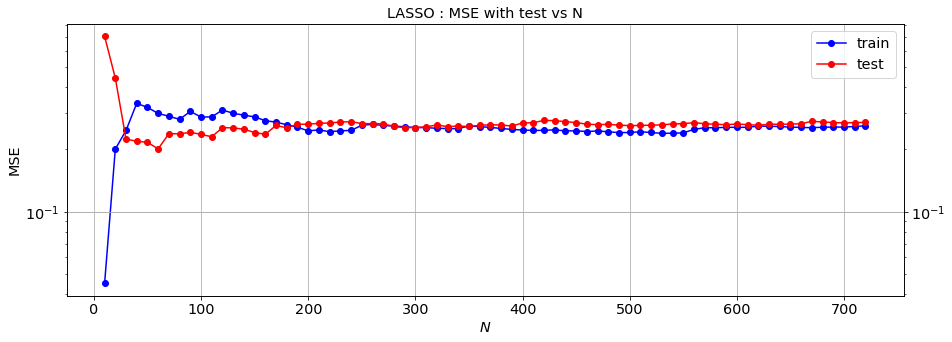

In [223]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [224]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [225]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


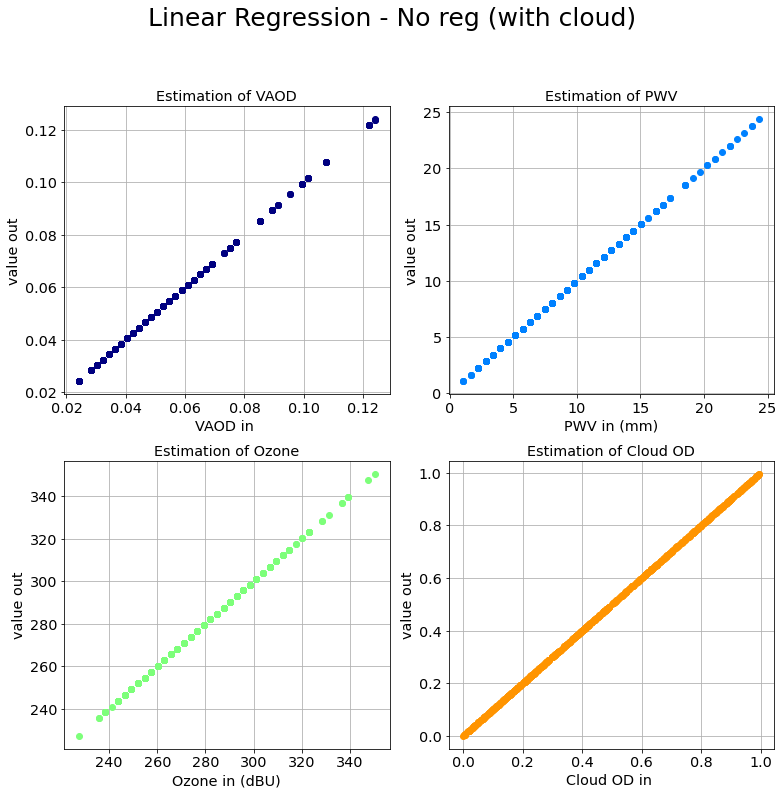

In [226]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

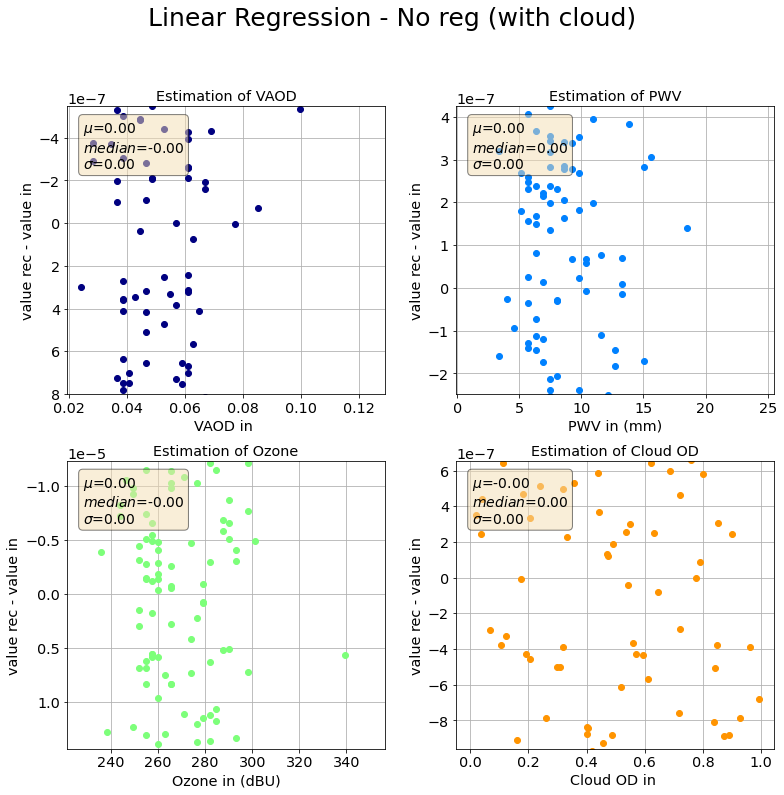

In [238]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

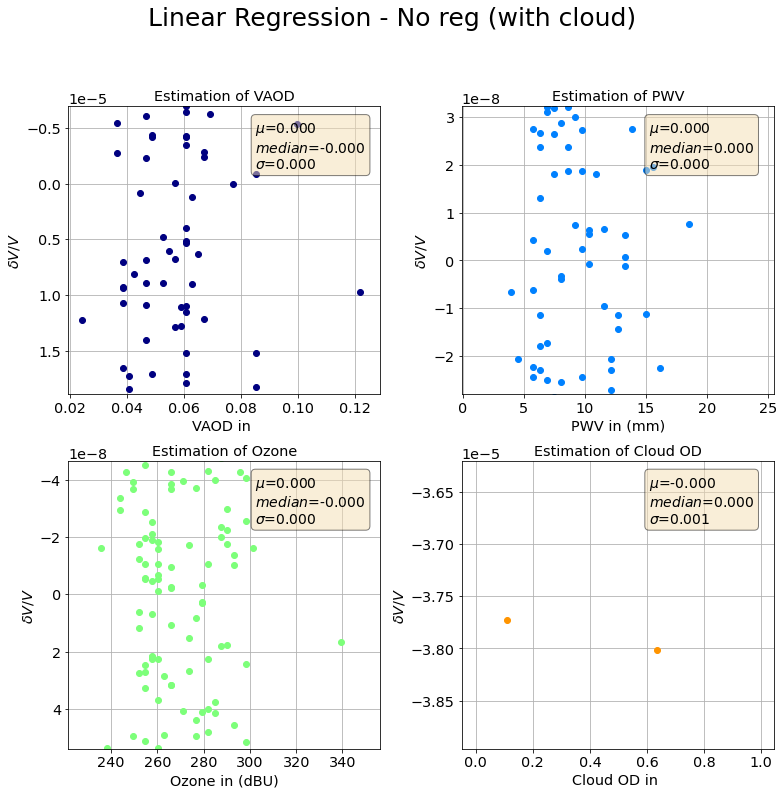

In [239]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

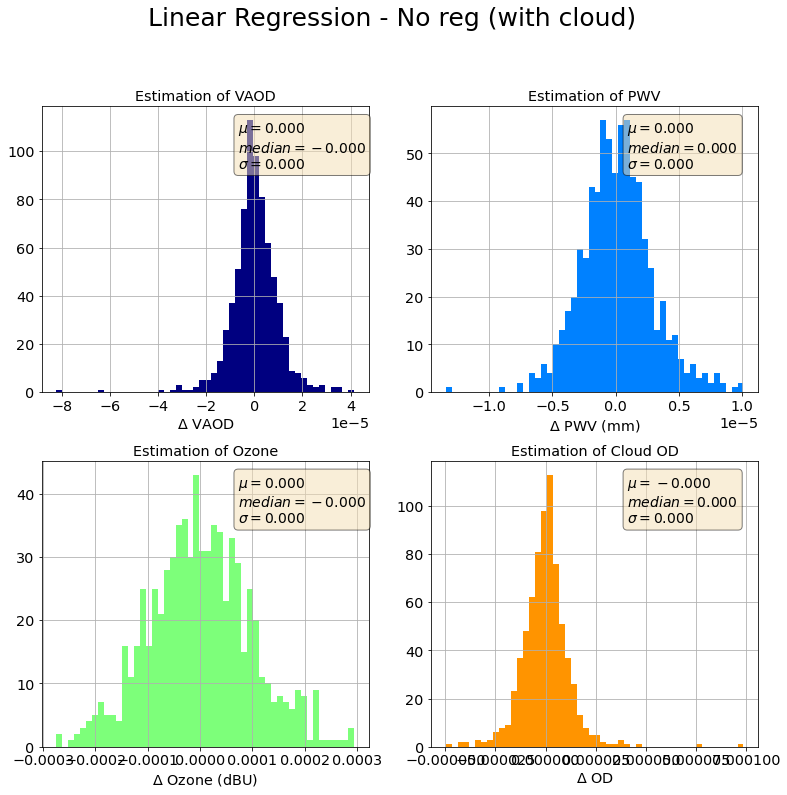

In [240]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()


## Ridge

In [ ]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
ridge.coef_

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

## Lasso

In [ ]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

In [ ]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()